In [27]:
import pandas as pd
import os
from config import MODEL_PATH

def load_samples_into_dataframe(folder_path="/proyect/DeepLearning MIT/GMM/data/"):
    all_samples = []

    for filename in os.listdir(folder_path):
        if filename.startswith("samples") and filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            all_samples.append(df)

    if all_samples:
        giant_df = pd.concat(all_samples, ignore_index=True)
        return giant_df
    else:
        print("No files starting with 'samples_' found.")
        return pd.DataFrame()

# Example usage:
giant_dataframe = load_samples_into_dataframe()

In [28]:
# Drop 'Unnamed: 0' column if it exists
if "Unnamed: 0" in giant_dataframe.columns:
    df2 = giant_dataframe.drop("Unnamed: 0", axis=1)
else:
    df2 = giant_dataframe.copy()

In [29]:
from scipy.spatial.distance import cosine

In [30]:
import numpy as np
import random

def clustering(X, k=3, max_iters=100):
    n=len(X)

    centroids_ind=list(range(len(X)))
    random.shuffle(centroids_ind)
    centroids_ind=centroids_ind[:k]
    centroids=[]
    for indi in centroids_ind:
      centroids.append([X[indi]])

    for _ in range(max_iters):
        distances = np.zeros((n, k))
        for j in range(k):
            if len(centroids[j]) > 0:
              for i in range(n):
                  distances[i, j] = np.sum((X[i] - centroids[j])**2)**0.5
            else:
              for i in range(n):
                  distances[i, j] = np.inf
                  #this goes right next to the cell above
        total_distances=0
        labels = []
        for i in range(n):
            labels.append(np.argmin(distances[i]))
            total_distances+=distances[i][labels[i]]
        print("total distances")
        print(total_distances)
        print()

        new_centroids = [[] for j in range(k)]
        for j in range(k):
            cluster_points = X[[l == j for l in labels]]
            if len(cluster_points) > 0:
                new_centroids[j] = cluster_points.mean(axis=0)

        centroids = new_centroids

    return labels, centroids, total_distances

In [31]:
from sklearn.metrics import adjusted_rand_score

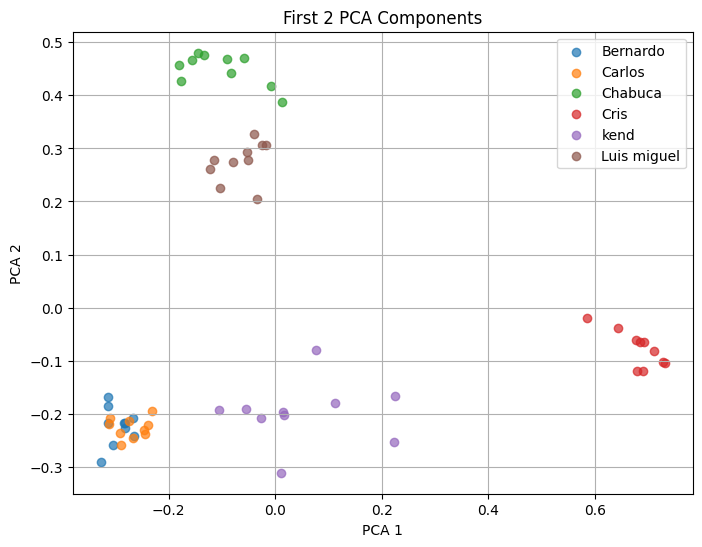

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Fit PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df2[[str(k) for k in range(256)]])

# Step 2: Save the components in df2
df2["pca1"] = pca_components[:, 0]
df2["pca2"] = pca_components[:, 1]

# Step 3: Plot the first two PCA components
plt.figure(figsize=(8,6))
for label in df2["label"].unique():
    subset = df2[df2["label"] == label]
    plt.scatter(subset["pca1"], subset["pca2"], label=label, alpha=0.7)
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("First 2 PCA Components")
plt.grid(True)
plt.show()

In [46]:
import random
import numpy as np
import seaborn as sns
import numpy as np                              # import numpy
from numpy.linalg import inv                    # for matrix inverse
import matplotlib.pyplot as plt                 # import matplotlib.pyplot for plotting framework
from scipy.stats import multivariate_normal     # for generating pdf

In [36]:
def Estep_n(d, mus, covs, pis, n):
    """
    E-step: Compute posterior probabilities (responsibilities) for each data point.
    
    Args:
        d: Data matrix of shape (num_samples, num_features)
        mus: List of mean vectors, each of shape (num_features,)
        covs: List of covariance matrices, each of shape (num_features, num_features)
        pis: Mixing weights (priors) of shape (n,)
        n: Number of components
    
    Returns:
        evals: Posterior probabilities (responsibilities) of shape (num_samples, n)
        weights: Unnormalized weights of shape (num_samples, n)
    """
    weights = np.zeros((len(d), n))

    for i in range(n):
        # multivariate_normal.pdf(X, mean=Y, cov=Z) Esta función te da el valor de la PMF de la normal (multivariada) en el punto X, de una normal con media Y y matriz de covarianzas Z
        # Calculate PDF for all data points under component i, then weight by prior probability
        weights[:, i] = pis[i] * multivariate_normal.pdf(d, mean=mus[i], cov=covs[i], allow_singular=True)

    weights_sum = np.sum(weights, axis=1, keepdims=True)
    evals = weights / weights_sum

    return evals, weights

In [38]:
def Mstep_n(d, evals, n):
    """
    M-step: Update the parameters of the Gaussian mixture model.
    
    Args:
        d: Data matrix of shape (num_samples, num_features)
        evals: Posterior probabilities (responsibilities) of shape (num_samples, n)
        n: Number of components
    
    Returns:
        mus: List of updated mean vectors
        covs: List of updated covariance matrices
        pis: Updated mixing weights
    """
    mus = []
    covs = []
    pis = []

    for i in range(n):
        responsibility = evals[:, i]
        total_resp = np.sum(responsibility)
        
        # Update mean: weighted average of data points
        mu = np.sum(responsibility.reshape(-1, 1) * d, axis=0) / total_resp
        mus.append(mu)

        # Update covariance: weighted diagonal covariance (spherical Gaussian)
        diff = d - mu
        # Compute weighted squared differences for diagonal variance
        weighted_sq_diff = np.sum(responsibility.reshape(-1, 1) * (diff ** 2), axis=0) / total_resp
        
        #Aquí forzamos a que la varianza de un componente nunca sea 0
        weighted_sq_diff = np.maximum(weighted_sq_diff, 1e-6)
        cov = np.diag(weighted_sq_diff)

        covs.append(cov)

        # Update mixing coefficient: average responsibility
        pis.append(total_resp / len(d))

    return mus, covs, pis

def compute_log_likelihood(d, mus, covs, pis):
    total = 0
    for i in range(len(d)):
        p = 0
        for k in range(len(mus)):
            p += pis[k] * multivariate_normal.pdf(d[i], mus[k], covs[k], allow_singular=True)
        total += np.log(p + 1e-12)
    return total

In [44]:
#incomplete

# Parameters
n = 6  # Number of Gaussians

# Data
cols=[str(k) for k in range(10)]
toremove=[]

for k in cols:
  if (np.var(df2[k]))<1e-6:
    toremove.append(k)

for k in toremove:
  cols.remove(k)

maxi=0
d = np.array(df2[cols])

# Randomly pick initial means
mus = [random.choice(d) for _ in range(n)]

# Initialize all covariances the same
covs = [np.cov(df2[cols].T) for _ in range(n)]

# Initialize mixing coefficients equally
pis = [1/n for _ in range(n)]

iterations = 100

i=0
lls=[]
prev_LL = None
tolerance = 1e-6  # Convergence threshold for early stopping

while i<iterations:
    evals, weights = Estep_n(d, mus, covs, pis, n)
    mus, covs, pis = Mstep_n(d, evals, n)
    LL = compute_log_likelihood(d, mus, covs, pis)
    print(f"Iteration {i+1}: Log-likelihood = {LL}")
    lls.append(LL)
    
    # Early stopping: check if log-likelihood has converged
    if prev_LL is not None:
        improvement = LL - prev_LL
        if improvement < tolerance:
            print(f"Converged at iteration {i+1}. Improvement: {improvement:.2e} < {tolerance}")
            break
    
    prev_LL = LL
    i+=1

# After EM algorithm completes, assign clusters to data points
# Get final posterior probabilities with converged parameters
final_evals, final_weights = Estep_n(d, mus, covs, pis, n)

# Assign each data point to the cluster with the highest probability (hard assignment)
cluster_labels = np.argmax(final_evals, axis=1)

print(f"\n{'='*50}")
print(f"Cluster Assignment Summary:")
print(f"{'='*50}")
print(f"Total data points: {len(cluster_labels)}")
print(f"Number of clusters: {n}")
print(f"\nPoints per cluster:")
for cluster_id in range(n):
    count = np.sum(cluster_labels == cluster_id)
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} points ({percentage:.1f}%)")

# Store cluster assignments in dataframe if df2 exists
if 'df2' in globals():
    df2['cluster'] = cluster_labels
    print(f"\nCluster assignments added to df2 as 'cluster' column")

# Also store soft assignments (probabilities) for analysis
print(f"\nFinal posterior probabilities (evals) shape: {final_evals.shape}")
print(f"Each row sums to 1.0 (probability distribution over clusters)")

Iteration 1: Log-likelihood = 1163.9635321954083
Iteration 2: Log-likelihood = 1369.4098556790325
Iteration 3: Log-likelihood = 1458.445967711983
Iteration 4: Log-likelihood = 1487.145437502116
Iteration 5: Log-likelihood = 1499.975873685476
Iteration 6: Log-likelihood = 1516.9217808325582
Iteration 7: Log-likelihood = 1522.7675201281975
Iteration 8: Log-likelihood = 1524.302632264704
Iteration 9: Log-likelihood = 1532.6569663214705
Iteration 10: Log-likelihood = 1557.365867970192
Iteration 11: Log-likelihood = 1565.1777889199416
Iteration 12: Log-likelihood = 1565.181466227203
Iteration 13: Log-likelihood = 1565.1826684236864
Iteration 14: Log-likelihood = 1565.1831408444993
Iteration 15: Log-likelihood = 1565.1833471613095
Iteration 16: Log-likelihood = 1565.1834434651103
Iteration 17: Log-likelihood = 1565.1834904456246
Iteration 18: Log-likelihood = 1565.183514067529
Iteration 19: Log-likelihood = 1565.183526198379
Iteration 20: Log-likelihood = 1565.1835325222485
Iteration 21: Log

In [49]:
# Comprehensive Clustering Evaluation Metrics
from sklearn.metrics import (
    adjusted_rand_score, 
    normalized_mutual_info_score,
    silhouette_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)
import pandas as pd
import numpy as np

print(f"{'='*60}")
print(f"CLUSTERING EVALUATION METRICS")
print(f"{'='*60}\n")

# Check if we have true labels
has_true_labels = 'df2' in globals() and 'label' in df2.columns

if has_true_labels:
    true_labels = df2['label'].values
    
    # 1. Adjusted Rand Index (ARI) - Measures similarity between clusters and true labels
    # Range: [-1, 1], where 1 = perfect match, 0 = random
    ari = adjusted_rand_score(true_labels, cluster_labels)
    print(f"1. Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"   Interpretation: {'Excellent' if ari > 0.9 else 'Good' if ari > 0.7 else 'Fair' if ari > 0.5 else 'Poor'} match with true labels\n")
    
    # 2. Normalized Mutual Information (NMI)
    # Range: [0, 1], where 1 = perfect match
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"2. Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"   Interpretation: {'Excellent' if nmi > 0.9 else 'Good' if nmi > 0.7 else 'Fair' if nmi > 0.5 else 'Poor'} agreement\n")
    
    # 3. Homogeneity, Completeness, and V-measure
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)
    v_measure = v_measure_score(true_labels, cluster_labels)
    
    print(f"3. Homogeneity: {homogeneity:.4f}")
    print(f"   (Each cluster contains only members of a single class)\n")
    print(f"4. Completeness: {completeness:.4f}")
    print(f"   (All members of a given class are assigned to the same cluster)\n")
    print(f"5. V-measure: {v_measure:.4f}")
    print(f"   (Harmonic mean of homogeneity and completeness)\n")
    
    # 6. Confusion Matrix
    print(f"6. Confusion Matrix (rows=predicted clusters, cols=true labels):")
    cm = confusion_matrix(true_labels, cluster_labels)
    cm_df = pd.DataFrame(cm, 
                        index=[f'Cluster {i}' for i in range(n)],
                        columns=sorted(df2['label'].unique()))
    print(cm_df)
    print()
    
    # 7. Cluster Purity - Average of max purity per cluster
    cluster_purities = []
    for cluster_id in range(n):
        cluster_mask = cluster_labels == cluster_id
        if np.sum(cluster_mask) > 0:
            cluster_true_labels = true_labels[cluster_mask]
            if len(cluster_true_labels) > 0:
                purity = np.max(np.bincount(cluster_true_labels)) / len(cluster_true_labels)
                cluster_purities.append(purity)
    
    avg_purity = np.mean(cluster_purities) if cluster_purities else 0
    print(f"7. Average Cluster Purity: {avg_purity:.4f}")
    print(f"   Interpretation: Average proportion of dominant class in each cluster\n")
else:
    print("True labels not available. Skipping supervised metrics.\n")

# 8. Silhouette Score - Internal validation (doesn't require true labels)
# Range: [-1, 1], where 1 = excellent separation, -1 = poor separation
silhouette = None
try:
    silhouette = silhouette_score(d, cluster_labels)
    print(f"8. Silhouette Score: {silhouette:.4f}")
    print(f"   Interpretation: {'Excellent' if silhouette > 0.7 else 'Good' if silhouette > 0.5 else 'Fair' if silhouette > 0.3 else 'Poor'} cluster separation")
    print(f"   (Higher is better, measures how similar points are to their cluster vs others)\n")
except Exception as e:
    print(f"8. Silhouette Score: Could not compute ({str(e)})\n")

# 9. Model Complexity Metrics
# Bayesian Information Criterion (BIC) - Lower is better
# BIC = -2 * log_likelihood + k * log(n)
# where k = number of parameters, n = number of samples
num_params = n * (d.shape[1] + d.shape[1] + 1) - 1  # n*(means + variances + weights) - 1 (weights sum to 1)
# means: n * d dimensions, variances: n * d dimensions, weights: n - 1 (last is determined)

# Alternative calculation for diagonal covariance
num_params = n * d.shape[1] + n * d.shape[1] + (n - 1)  # means + diagonal variances + mixing weights
final_LL = compute_log_likelihood(d, mus, covs, pis)
bic = -2 * final_LL + num_params * np.log(len(d))
aic = -2 * final_LL + 2 * num_params

print(f"9. Model Complexity Metrics:")
print(f"   Log-Likelihood: {final_LL:.4f}")
print(f"   Number of parameters: {num_params}")
print(f"   AIC (Akaike Information Criterion): {aic:.4f} (lower is better)")
print(f"   BIC (Bayesian Information Criterion): {bic:.4f} (lower is better)")
print(f"   Interpretation: BIC penalizes complexity more than AIC\n")

# 10. Cluster separation quality
print(f"10. Cluster Separation Quality:")
for cluster_id in range(n):
    cluster_mask = cluster_labels == cluster_id
    cluster_points = d[cluster_mask]
    if len(cluster_points) > 0:
        avg_prob = np.mean(final_evals[cluster_mask, cluster_id])
        print(f"   Cluster {cluster_id}: {len(cluster_points)} points, avg assignment probability: {avg_prob:.4f}")

print(f"\n{'='*60}")
print(f"SUMMARY")
print(f"{'='*60}")
if has_true_labels:
    print(f"✓ Best match metric: ARI = {ari:.4f}")
    print(f"✓ Information overlap: NMI = {nmi:.4f}")
if silhouette is not None:
    print(f"✓ Cluster quality: Silhouette = {silhouette:.4f}")
print(f"✓ Model fit: Log-Likelihood = {final_LL:.4f}, BIC = {bic:.4f}")
print(f"{'='*60}")


CLUSTERING EVALUATION METRICS

1. Adjusted Rand Index (ARI): 0.5945
   Interpretation: Fair match with true labels

2. Normalized Mutual Information (NMI): 0.7135
   Interpretation: Good agreement

3. Homogeneity: 0.7029
   (Each cluster contains only members of a single class)

4. Completeness: 0.7245
   (All members of a given class are assigned to the same cluster)

5. V-measure: 0.7135
   (Harmonic mean of homogeneity and completeness)

6. Confusion Matrix (rows=predicted clusters, cols=true labels):


ValueError: Mix of label input types (string and number)

<Axes: >

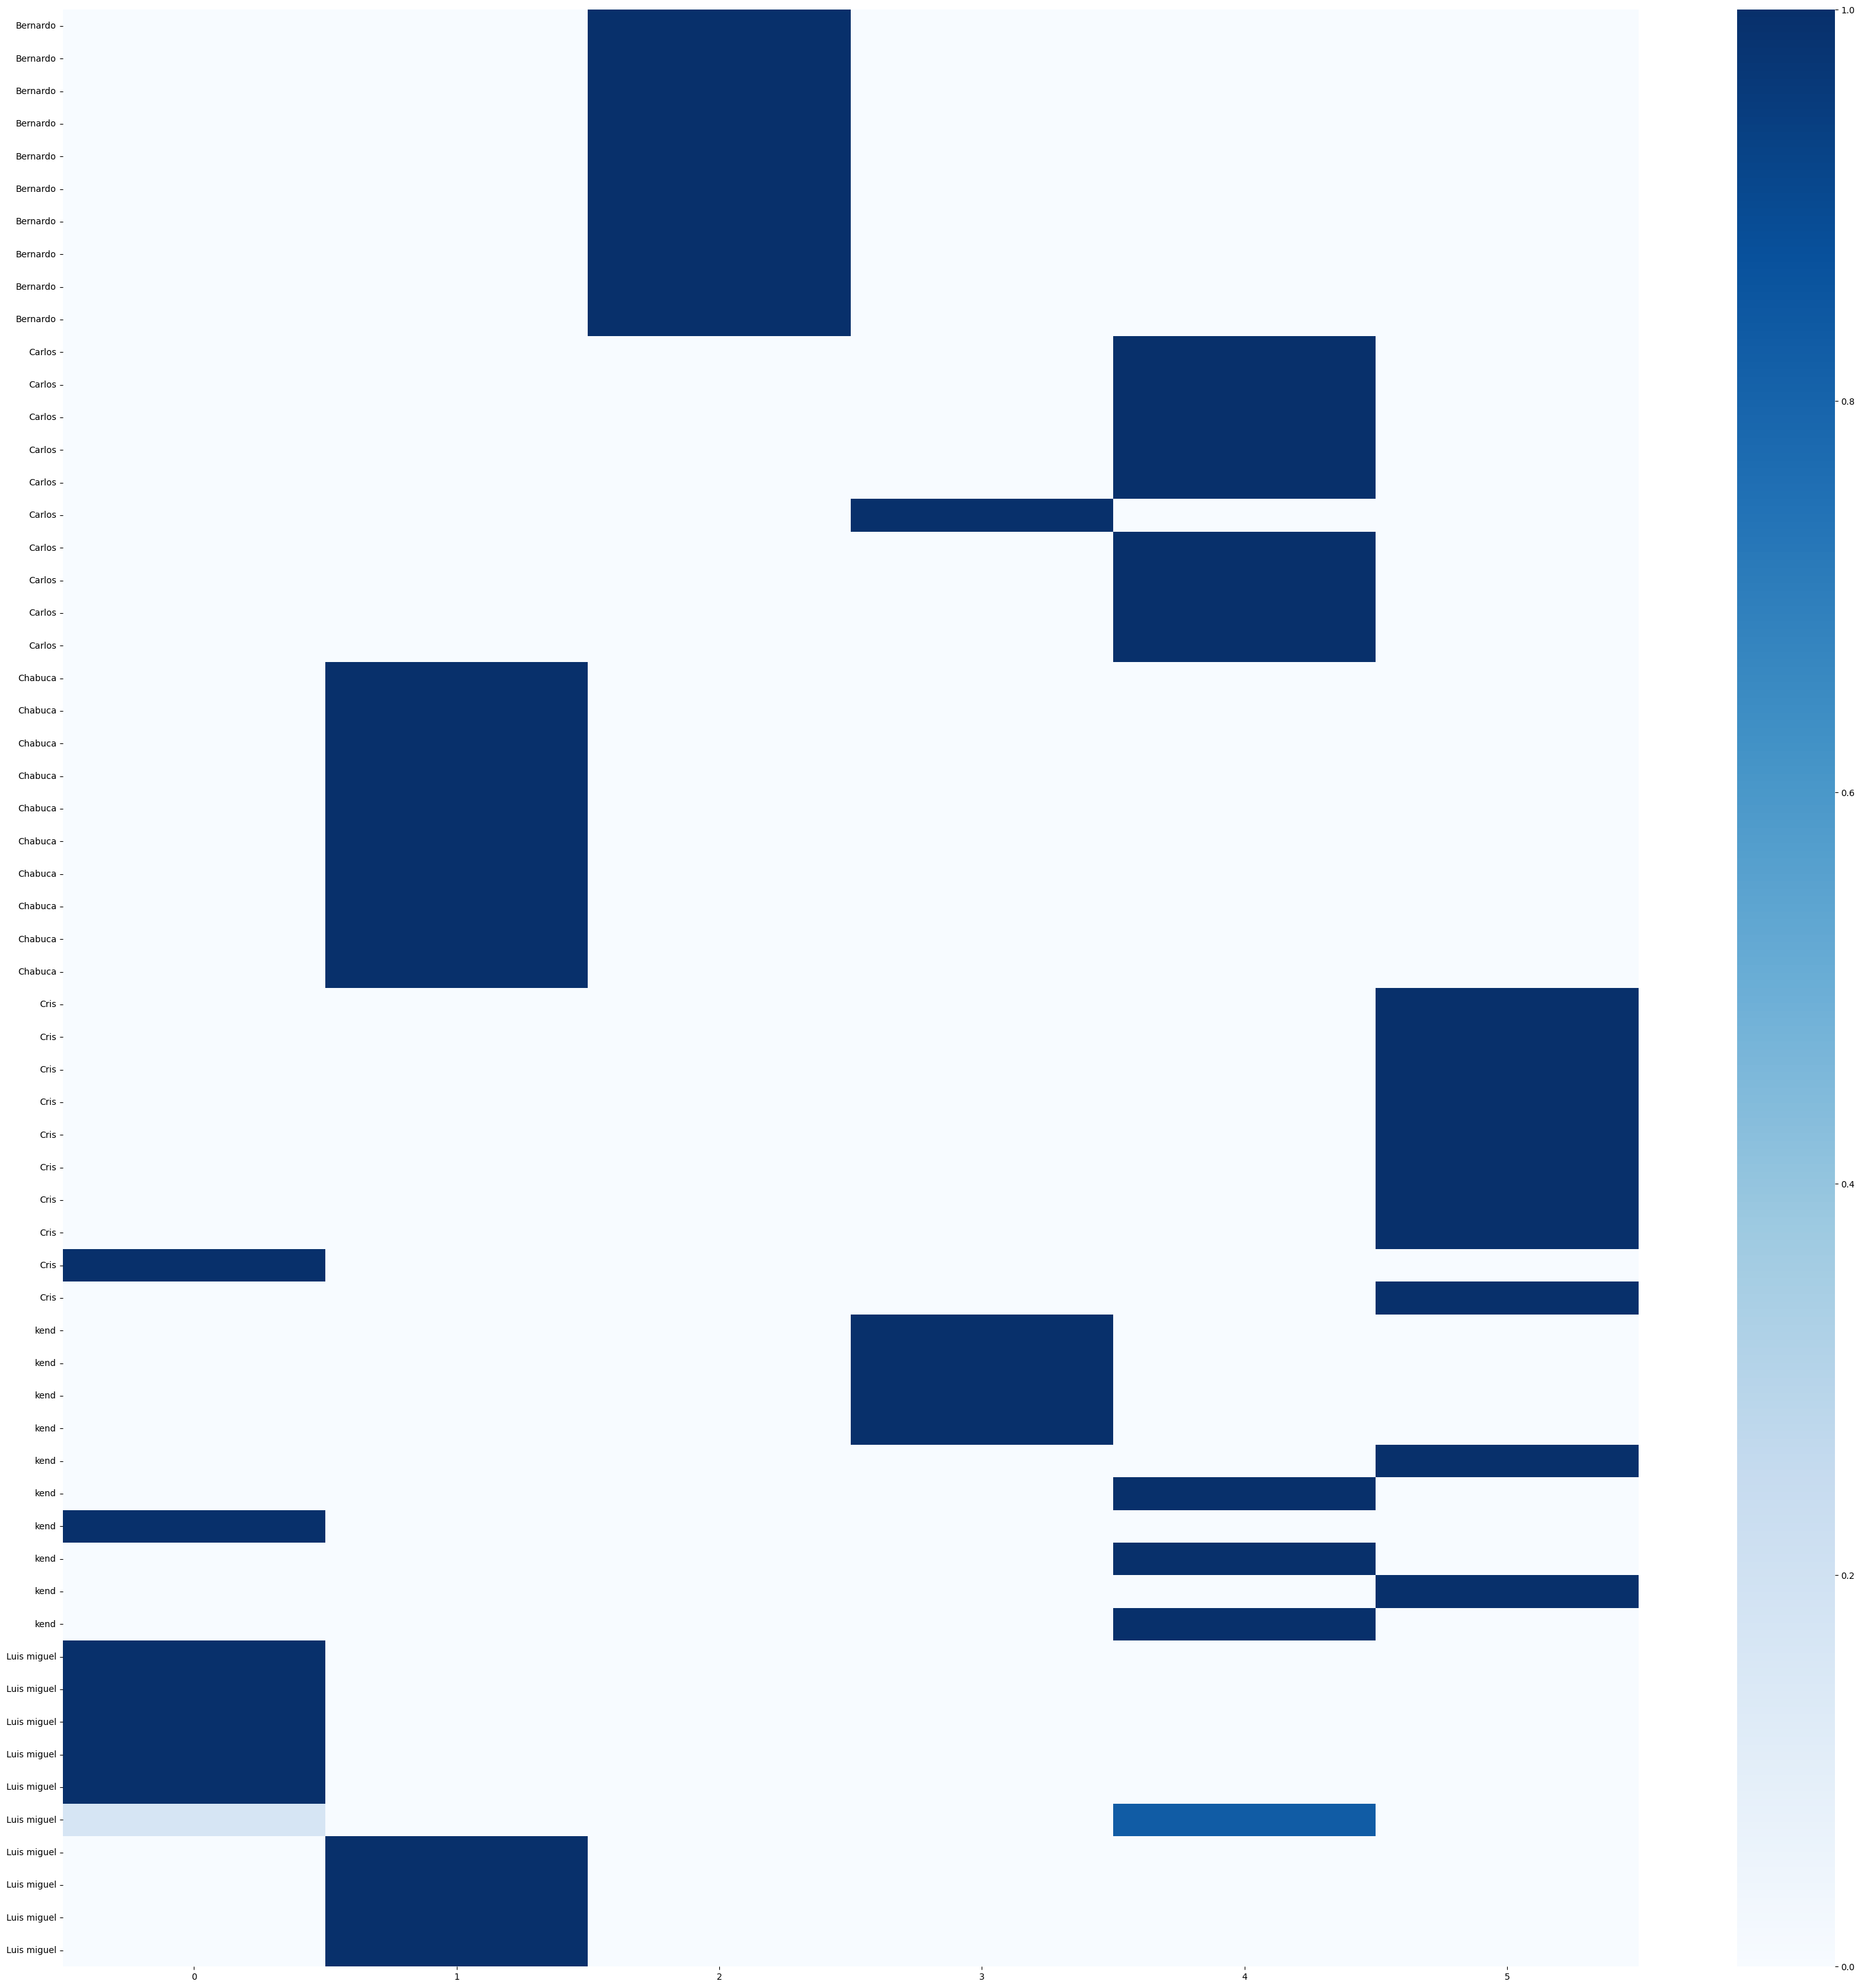

In [47]:
plt.figure(figsize=(40, 40))
sns.heatmap(evals,  cmap="Blues", annot=False, fmt=".2f",  yticklabels=df2["label"])